# Задача 1. Линейная регрессия, метод градиентного спуска

Задачу выполнил Степырев Даниил, студент 22.М-05мм группы.

## Данные, на которых решается задача

В задаче используется датасет электрических машин (ссылка).
Описание датасета:
- **Brand** --- марка автомобиля
- **Model** --- название модели автомобиля
- **AccelSec** --- время ускорения автомобиля 0-100 км/ч в секундах
- **TopSpeed_KmH** --- максимальная скорость в км/ч
- **Range_Km** --- запас хода в километрах
- **Efficiency_WhKm** --- эффективность (?)
- **FastCharge_KmH** --- скорость зарядки автомобиля: число добавленных километров в час
- **RapidCharge** --- возможность быстрой зарядки
- **PowerTrain** --- привод автомобиля
- **PlugType** --- тип зарядки
- **BodyStyle** --- тип кузова
- **Segment** --- класс автомобиля
- **Seats** --- количество пассажирских мест
- **PriceEuro** --- цена в евро

## Считывание данных

Подключаем используемые библиотеки:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [2]:
df = pd.read_csv('Dataset/electric-cars.csv')

Считываем обучающую выборку:

In [3]:
df.head()

,Brand,Model,Accel,TopSpeed,Range,Efficiency,FastCharge,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6 sec,233 km/h,450 km,161 Wh/km,940 km/h,Rapid charging possible,All Wheel Drive,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0 sec,160 km/h,270 km,167 Wh/km,250 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7 sec,210 km/h,400 km,181 Wh/km,620 km/h,Rapid charging possible,All Wheel Drive,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8 sec,180 km/h,360 km,206 Wh/km,560 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5 sec,145 km/h,170 km,168 Wh/km,190 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,Hatchback,B,4,32997


Общее количество пропущенных значений:

In [4]:
df.isnull().sum()

Brand          0
Model          0
Accel          0
TopSpeed       0
Range          0
Efficiency     0
FastCharge     0
RapidCharge    0
PowerTrain     0
PlugType       0
BodyStyle      0
Segment        0
Seats          0
PriceEuro      0
dtype: int64

Все признаки имеют заполненные значения значения.
Рассмотрим статистику по целевому признаку **PriceEuro**: сколько и каких значений он принимает. Воспользуемся функцией value_counts(): 

In [5]:
df['PriceEuro'].value_counts()

45000    6
50000    3
29234    2
30000    2
36837    2
        ..
38105    1
67358    1
34361    1
38017    1
62000    1
Name: PriceEuro, Length: 87, dtype: int64

Видим, что **PriceEuro** принимает 87 различных значений. Посчитаем минимальную, максимальную и среднюю цену:

In [6]:
df['PriceEuro'].min()

20129

In [7]:
df['PriceEuro'].max()

215000

In [8]:
df['PriceEuro'].mean()

55811.5631

Выяснили, что поле **PriceEuro** принимает значения от 20129 до 215000. Средняя цена электромобиля: 55811.

## Первичный анализ данных

### Признак Brand

Выясним, какой тип имеет признак **Марка** в датасете:

Выясним, сколько электрических автомобилей доступно у определённой **марки**. Отобразим эти значения на графике:

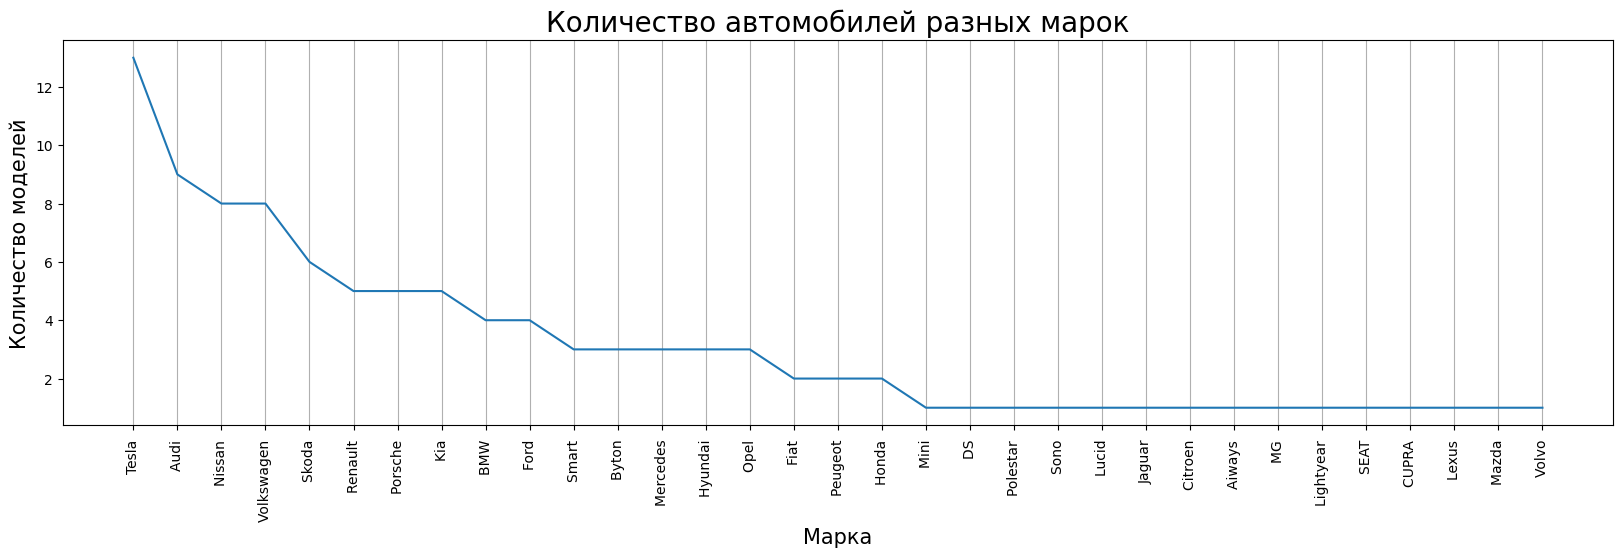

In [9]:
plt.figure(figsize=(20,5))
plt.grid(axis="x")
plt.xticks(rotation = 90)
plt.title('Количество автомобилей разных марок', fontsize = 20)
plt.xlabel('Марка', fontsize= 15)
plt.ylabel('Количество моделей', fontsize= 15)
plt.plot(df["Brand"].value_counts())
plt.show()

Видим, что в датасете представлено больше всего электромобилей марки *Tesla*, *Audi* и *Nissan*. Марки *Mini*, *DS*, *Polestar*, *Sono*, *Lucid*, *Jaguar*, *Citroern*, *Aiways*, *MG*, *Lightyear*, *SEAT*, *CUPRA*, *Lexus*, *Mazda*, *Volvo* имеют в датасете всего по одной представленной модели.

Посмотрим график стоимости автомобиля *PriceEuro* в зависимости от марки:

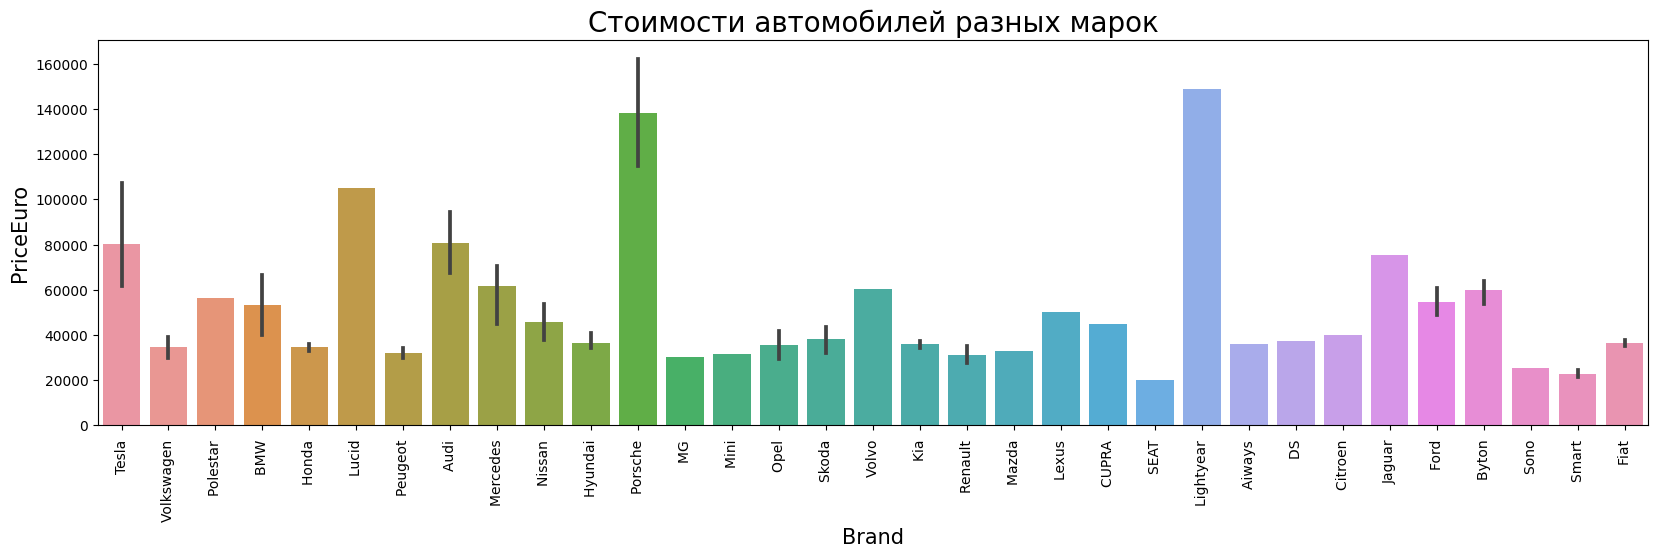

In [10]:
plt.figure(figsize=(20,5))
plt.grid(axis="x")
plt.xticks(rotation = 90)
plt.title('Стоимости автомобилей разных марок', fontsize = 20)
plt.xlabel('Марка', fontsize= 15)
plt.ylabel('Цена автомобиля в евро', fontsize= 15)
sns.barplot(x = df["Brand"], y = df["PriceEuro"])
plt.show()

Из графика видно, что большинство автомобилей в датасете стоят от 40000 до 60000 евро. Самые дорогие автомобили у марок *Porsche* и *Lightyear*, а самые бюджетные у *SEAT* и *Smart*.

### Признак Model

Выясним, сколько стоят автомобиля определённой **модели**. Отобразим эти значения на графике:

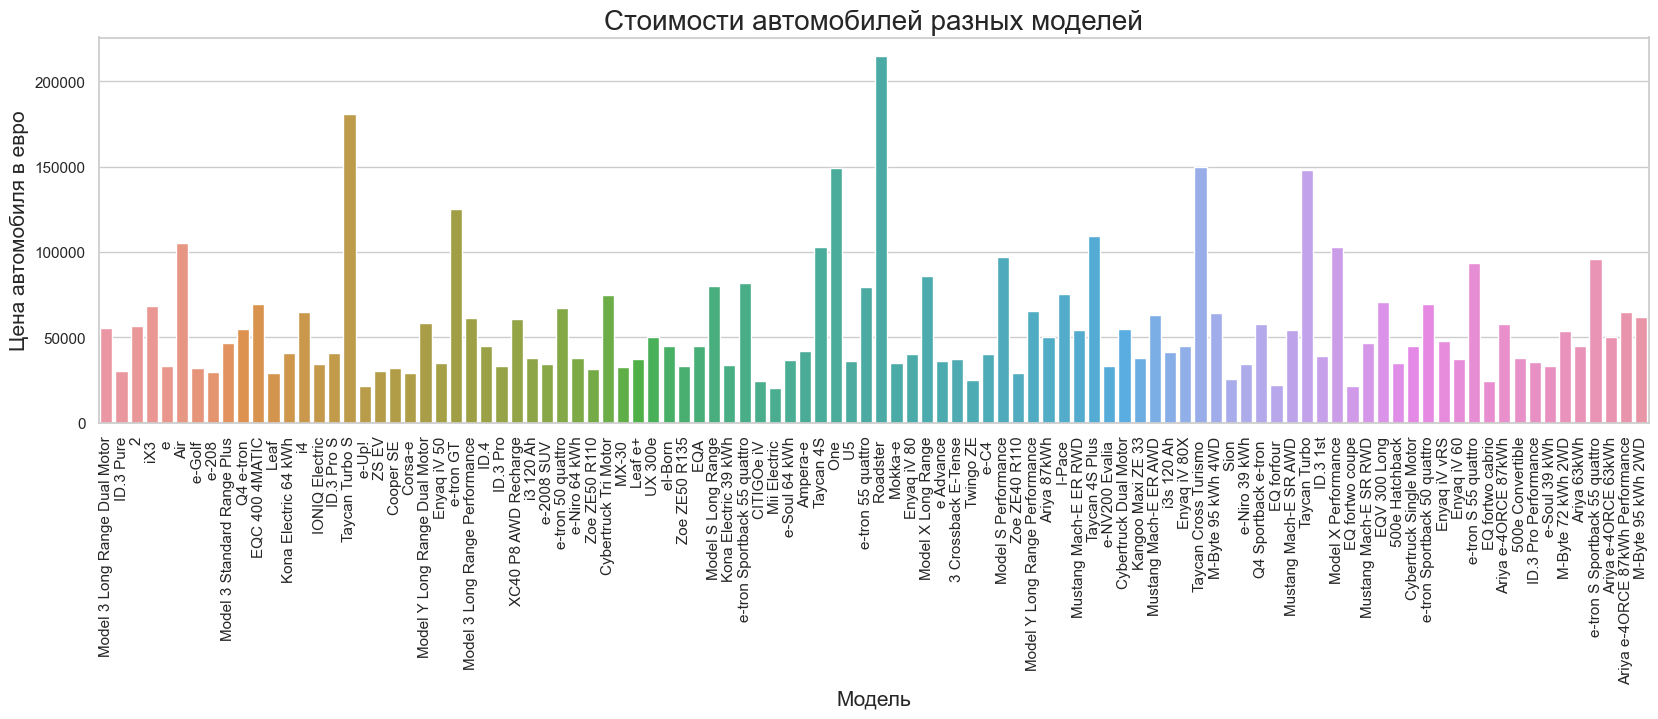

In [11]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "Model", y = "PriceEuro", data = df)
plt.title('Стоимости автомобилей разных моделей', fontsize = 20)
plt.ylabel('Цена автомобиля в евро', fontsize= 15)
plt.xlabel('Модель', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

Видим более подробное график цен автомобилей и их стоимости. Из графика видно, что электических автомобили можно разделить по стоимости на две группы: дешевле 50000 евро и дороже 50000 евро.

Также можно заметить, что признак **Model** и признак **Brand** имеют много уникальных значений. На ценообразование машины может влиять страна, в которой автомобиль был разработан. Для определения страны производителя, напишем небольшую функцию `get_origin_country(brand)`:

In [21]:
def get_origin_country(brand):
    if (brand == "Mercedes" or brand == "Porsche" or brand == "Mini"
       or brand == "Volkswagen" or brand == "BMW" or brand == "Audi"
       or brand == "Opel" or brand == "Sono" or brand == "Smart"):
        return "Germany"
    
    if (brand == "Peugeot" or brand == "Nissan" or brand == "Renault"
       or brand == "DS" or brand == "Citroen"):
        return "France"
    
    if (brand == "Honda" or brand == "Mazda" or brand == "Lexus"):
        return "Japan"
    
    if (brand == "Tesla" or brand == "Lucid" or brand == "Ford"):
        return "USA"
    
    if (brand == "Polestar" or brand == "Volvo"):
        return "Sweden"

    if (brand == "Hyundai" or brand == "Kia"):
        return "Korea"
    
    if (brand == "Cupra" or brand == "SEAT"):
        return "Spain"
    
    if (brand == "MG" or brand == "Jaguar"):
        return "England"
    
    if (brand == "Aiweys" or brand == "Byton"):
        return "China"

    if (brand == "Lightyear"):
        return "Finland"    
    
    if (brand == "Skoda"):
        return "Czech"
    
    if (brand == "Fiat"):
        return "Italy"
    
    return "Other"

Введём новый признак **OriginCountry** и проверим это предположение:

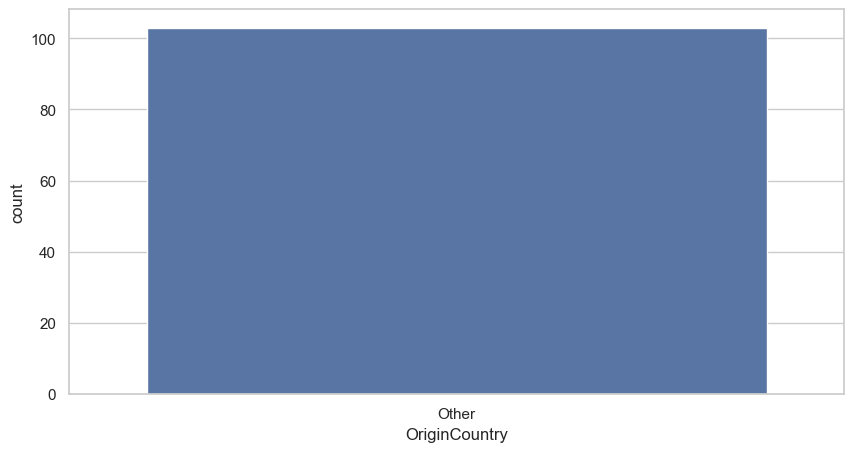

In [22]:
df['OriginCountry'] = df['Brand'].apply(lambda x: get_origin_country(x))
sns.countplot(x=df['OriginCountry'])
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [14]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.countplot(x = df['FullName'])
plt.title('Количество автомобилей разных марок и моделей', fontsize = 20)
plt.ylabel('Количество', fontsize= 15)
plt.xlabel('Марка и модель автомобиля', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

KeyError: 'FullName'

<Figure size 2000x500 with 0 Axes>